In [1]:
# work environment: jl2815
# Standard libraries
import sys
import logging
import argparse # Argument parsing
import math
from collections import defaultdict
import concurrent
from concurrent.futures import ThreadPoolExecutor  # Importing specific executor for clarity
import time

# Data manipulation and analysis
import pandas as pd
import numpy as np

# Nearest neighbor search
import sklearn
from sklearn.neighbors import BallTree

# Special functions and optimizations
from scipy.special import gamma, kv  # Bessel function and gamma function
from scipy.stats import multivariate_normal  # Simulation
from scipy.optimize import minimize
from scipy.spatial.distance import cdist  # For space and time distance
from scipy.spatial import distance  # Find closest spatial point
from scipy.optimize import differential_evolution

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Type hints
from typing import Callable, Union, Tuple

# Add your custom path
sys.path.append("/cache/home/jl2815/tco")

# Custom imports
from GEMS_TCO import orbitmap 
from GEMS_TCO import kernels 
from GEMS_TCO import smoothspace

import pickle

# Summary

In this experiment, we assess how the Vecchia approximation is accurate by comparing two normalized values:

$ \frac{ Prediction(full)- \mu(full)} {\sigma(full)}$ vs $ \frac{ Prediction(full) - \mu(vecchia)} {\sigma(vecchia)}.$

To elaborate on second term; if $x_j$ is conditioned on $x_{i1},...,x_{i10},$ then I use these 10 points to calculate the coefficient for BLP and others instead of using the entire $x_1,..., x_{j-1}, x_{j+1},..., x_n$.

First one is supposed to be normal, and if the vecchia approximation is good enough approximating the full covariance structure, then we expect the second to be nearly standard normal as well. 

However that is not the case. This is because Vecchia approximation results in smaller standard deviation because it chooses the most relevant set as conditioning set, not the entire past data. 

--> Based on this experiment, I plan to clip the conditional standard deviation by  max(sd, 7), where 7 represents the general conditional standard deviation. 

#### Data setup

I picked a time with 20,000 data points. Then I chose a coarse set by choosing every 5th point both in latitude and longitude resulting in 800 data points. 

In [2]:
lat_lon_resolution = [15,15]
mm_cond_number = 10
params= [60, 5.25, 5.25, 0.2, 0.5, 5]
key_for_dict= 8


# Load the one dictionary to set spaital coordinates
filepath = "C:/Users/joonw/TCO/data_engineering/data_2023/sparse_cen_map23_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y23m01day01_hm02:12']

sample_key = coarse_dict_24_1.get('y23m01day01_hm02:12')
if sample_key is None:
    print("Key 'y23m01day01_hm02:12' not found in the dictionary.")

# { (20,20):(5,1), (5,5):(20,40) }
rho_lat = lat_lon_resolution[0]          
rho_lon = lat_lon_resolution[1]
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

lat_number = len(lat_n)
lon_number = len(lon_n)

# Set spatial coordinates for each dataset
coarse_dicts = {}

years = ['2024']
for year in years:
    for month in range(7, 8):  # Iterate over all months
        filepath = f"C:/Users/joonw/TCO/data_engineering/data_{year}/sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)


key_idx = sorted(coarse_dicts)
if not key_idx:
    raise ValueError("coarse_dicts is empty")

# extract first hour data because all data shares the same spatial grid
data_for_coord = coarse_dicts[key_idx[0]]
x1 = data_for_coord['Longitude'].values
y1 = data_for_coord['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)

instance = orbitmap.MakeOrbitdata(data_for_coord, lat_s=5, lat_e=10, lon_s=110, lon_e=120)
s_dist = cdist(coords1, coords1, 'euclidean')
ord_mm, _ = instance.maxmin_naive(s_dist, 0)

data_for_coord = data_for_coord.iloc[ord_mm].reset_index(drop=True)
coords1_reordered = np.stack((data_for_coord['Longitude'].values, data_for_coord['Latitude'].values), axis=-1)
nns_map = instance.find_nns_naive(locs=coords1_reordered, dist_fun='euclidean', max_nn=mm_cond_number)


key_for_dict= 1
analysis_data_map = {}
for i in range(key_for_dict):
    tmp = coarse_dicts[key_idx[i]]
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed'])
    # tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    analysis_data_map[key_idx[i]] = tmp

aggregated_data = pd.DataFrame()
for i in range((key_for_dict)):
    tmp = coarse_dicts[key_idx[i]]
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:,:4].to_numpy()

print(f'Aggregated data shape: {aggregated_data.shape}')



Aggregated data shape: (98, 5)


Diagnosis

Aggregated data shape: (196, 5)


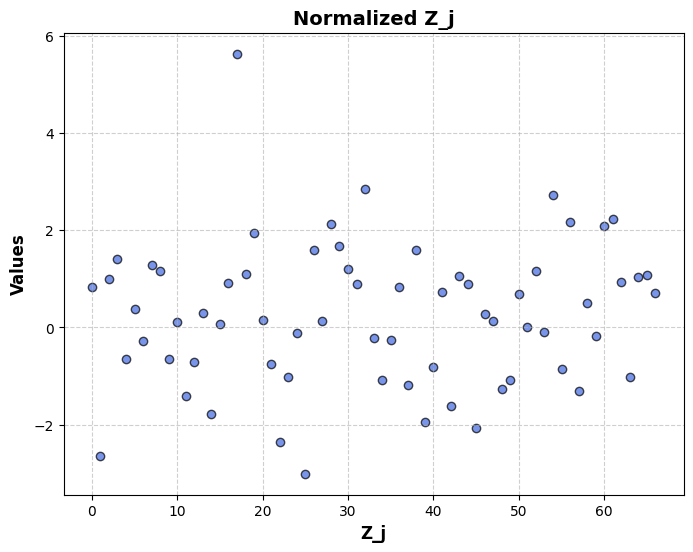

In [29]:
params= [11.73, 0.05, 0.05, -0.10, 0.25, 0.055 ] # vecchia data 50*x
# params = [31.38, 4.61, 3.36, 9.26e-04 ,0.25, 0.05]

# params = [8.98, 0.05, 0.05, -0.04, 0.98, 0.5] # vecchia data 200*x8

params = [16.20, 2.78, 7.55, -0.24, 0.25, 0.5] # vecchia
key_for_dict= 2
analysis_data_map = {}
for i in range(key_for_dict):
    tmp = coarse_dicts[key_idx[i]]
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed'])
    # tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    analysis_data_map[key_idx[i]] = tmp
aggregated_data = pd.DataFrame()
for i in range((key_for_dict)):
    tmp = coarse_dicts[key_idx[i]]
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:,:4].to_numpy()

print(f'Aggregated data shape: {aggregated_data.shape}')
instance1 = kernels.matern_spatio_temporal(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)

instance2 = kernels.diagnosis(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)
# data = data.iloc[ord, :]


res = instance2.diagnosis_method1(params, instance1.matern_cov_yx )

y = res[1][31:]
index = range(len(y))

plt.figure(figsize=(8,6))  # Increase figure size
plt.scatter(index, y, color='royalblue', edgecolors='black', alpha=0.7)  # Improve visibility
plt.grid(True, linestyle='--', alpha=0.6)  # Adjust grid style
plt.xlabel('Z_j', fontsize=12, fontweight='bold')
plt.ylabel('Values', fontsize=12, fontweight='bold')
plt.title('Normalized Z_j', fontsize=14, fontweight='bold')
plt.show()


In [38]:
from scipy.stats import norm,uniform
priors = [
    norm(loc=15, scale=10),  # Prior for parameter sigmasq
    uniform(loc=0.1, scale=8),  # Prior for parameter range_lat
    uniform(loc=0.1, scale=15),  # Prior for parameter range_lon
    uniform(loc=0.01, scale=2),  # Prior for parameter advection
    uniform(loc=0.01, scale=2),   # Prior for parameter beta
    uniform(loc=0.01, scale=1)   # Prior for parameter nugget
    
]

# Define some parameter values to evaluate
params = [15, 4, 10, 1, 0.5, 0.1]

# Calculate the logpdf for each parameter value
logpdf_values = [prior.logpdf(param) for prior, param in zip(priors, params)]
for i, logpdf_value in enumerate(logpdf_values):
    print(f"Logpdf of Prior {i} at value {params[i]}: {logpdf_value}")



Logpdf of Prior 0 at value 15: -3.2215236261987186
Logpdf of Prior 1 at value 4: -2.0794415416798357
Logpdf of Prior 2 at value 10: -2.70805020110221
Logpdf of Prior 3 at value 1: -0.6931471805599453
Logpdf of Prior 4 at value 0.5: -0.6931471805599453
Logpdf of Prior 5 at value 0.1: 0.0


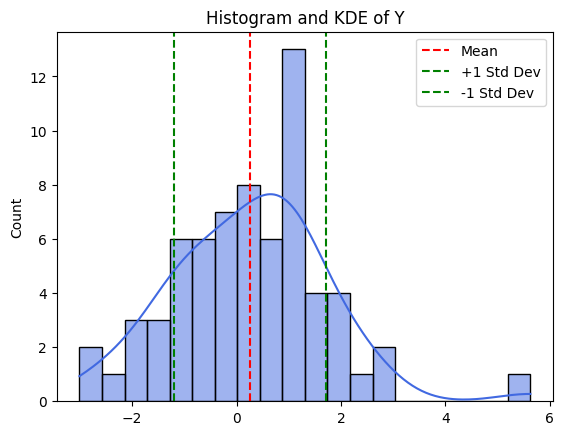

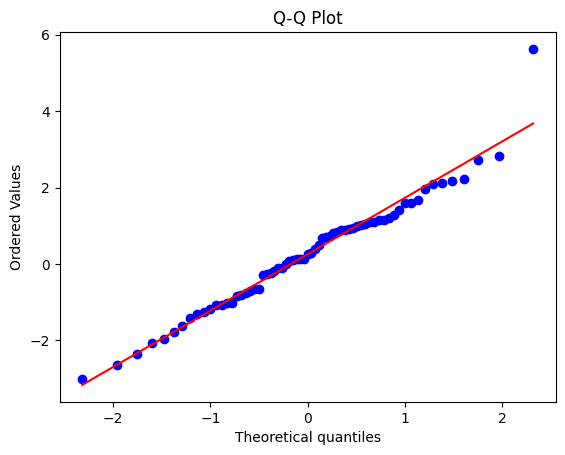

Shapiro-Wilk test statistic: 0.9721500977179927, p-value: 0.137391077711775


In [32]:
import seaborn as sns
import numpy as np

sns.histplot(y, kde=True, bins=20, color='royalblue')
plt.axvline(np.mean(y), color='red', linestyle='--', label='Mean')
plt.axvline(np.mean(y) + np.std(y), color='green', linestyle='--', label='+1 Std Dev')
plt.axvline(np.mean(y) - np.std(y), color='green', linestyle='--', label='-1 Std Dev')
plt.legend()
plt.title("Histogram and KDE of Y")
plt.show()

import scipy.stats as stats

stats.probplot(y, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

from scipy.stats import shapiro

stat, p = shapiro(y)
print(f"Shapiro-Wilk test statistic: {stat}, p-value: {p}")


Likelihood

In [ ]:
key_for_dict= 8
analysis_data_map = {}
for i in range(key_for_dict):
    tmp = coarse_dicts[key_idx[i]]
    tmp['Hours_elapsed'] = np.round(tmp['Hours_elapsed'])
    # tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    tmp = tmp.iloc[ord_mm, :4].to_numpy()
    analysis_data_map[key_idx[i]] = tmp
aggregated_data = pd.DataFrame()
for i in range((key_for_dict)):
    tmp = coarse_dicts[key_idx[i]]
    tmp = tmp.iloc[ord_mm].reset_index(drop=True)  
    
    aggregated_data = pd.concat((aggregated_data, tmp), axis=0)

aggregated_np = aggregated_data.iloc[:,:4].to_numpy()

print(f'Aggregated data shape: {aggregated_data.shape}')
instance = kernels.matern_spatio_temporal(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)
# data = data.iloc[ord, :]



'''
start_time = time.time()

out = instance.full_likelihood(params, aggregated_np, aggregated_np[:,2], instance.matern_cov_yx)
print(out)
end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Full likelihood time took {estimation_time:.4f} seconds")
'''



start_time = time.time()
out2 = instance.vecchia_like_nocache(params, instance.matern_cov_yx)
print(out2)
end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Vecc1 time took {estimation_time:.4f} seconds")


start_time = time.time()

out3 = instance.vecchia_likelihood(params, instance.matern_cov_yx)
print(out3)

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Vecc2_time took {estimation_time:.4f} seconds")

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Vecc3_time took {estimation_time:.4f} seconds")

start_time = time.time()
out4 = instance.vecchia_like_using_cholesky(params, instance.matern_cov_yx)
print(out4)

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Vecc4_time took {estimation_time:.4f} seconds")


For small size of n , without cholesky factor might be faster but cholesky reduces inverse On cubic to O(n^3/3) 
also condition number gets better when using cholesky factor

Aggregated data shape: (40000, 5)
91423.47272215618
Vecc1 time took 217.3939 seconds
91423.47272215612
Vecc2_time took 39.4825 seconds
5000
91423.47272215622
Vecc3_time took 37.7864 seconds
5000
91423.47272215615
Vecc4_time took 37.5791 seconds (cholesky)

In [4]:
v=0.5
keys =[0, 8 ]
mm_cond_number=5 
params =[40, 5.25, 5.25, 0.3, 0.3, 0.5 ]
bounds = [ (0.05, 40) ,(0.05 ,15) ,(0.05, 15), (-15, 15), (0.25, 20), (0.05, 0.5)]

instance = kernels.matern_spatio_temporal(smooth = v, input_map = analysis_data_map, nns_map = nns_map, mm_cond_number = mm_cond_number )
# data = data.iloc[ord,:]

start_time = time.time()

# keys = sorted(analysis_data_map)
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    futures = [
        executor.submit(
            instance.mle_parallel_vecc,
            bounds, params, instance.matern_cov_yx
        )   
    
    ]

    for future in concurrent.futures.as_completed(futures):
        print(future.result())

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Vecchia estimation_time took {estimation_time:.4f} seconds")

'''
start_time = time.time()
# keys = sorted(analysis_data_map)
with concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:
    futures = [
        executor.submit(
            instance.mle_parallel_full,
            bounds, params, aggregated_np, aggregated_np[:,2],instance.matern_cov_yx
        )   
    ]

    for future in concurrent.futures.as_completed(futures):
        print(future.result())

end_time = time.time()  # Record the end time
estimation_time = end_time - start_time  # Calculate the time spent
print(f"Full likelihood estimation_time took {estimation_time:.4f} seconds")
'''

ERROR:root:Error occurred: Singular matrix


fit_st_1_27
200
Error occurred: Singular matrix
None
Vecchia estimation_time took 0.0080 seconds


'\nstart_time = time.time()\n# keys = sorted(analysis_data_map)\nwith concurrent.futures.ThreadPoolExecutor(max_workers=32) as executor:\n    futures = [\n        executor.submit(\n            instance.mle_parallel_full,\n            bounds, params, aggregated_np, aggregated_np[:,2],instance.matern_cov_yx\n        )   \n    ]\n\n    for future in concurrent.futures.as_completed(futures):\n        print(future.result())\n\nend_time = time.time()  # Record the end time\nestimation_time = end_time - start_time  # Calculate the time spent\nprint(f"Full likelihood estimation_time took {estimation_time:.4f} seconds")\n'

Total iterations: 26
Estimated parameters : [40.          7.07018661 10.19574596 -0.07198478  0.25        0.05      ], when cond 5, bounds=[(0.05, 40), (0.05, 15), (0.05, 15), (-15, 15), (0.25, 20), (0.05, 0.5)], smooth=0.5
Vecchia estimation_time took 56.1766 seconds

Total iterations: 26
Estimated parameters : [40.          7.07001762 10.19533494 -0.07197073  0.25        0.05      ], when cond 5, bounds=[(0.05, 40), (0.05, 15), (0.05, 15), (-15, 15), (0.25, 20), (0.05, 0.5)], smooth=0.5
Vecchia estimation_time took 24.8730 seconds


Total iterations: 46
Estimated parameters : [3.11611694e+01 4.54408111e+00 3.32554124e+00 1.04157030e-03
 2.50000000e-01 5.00000000e-02], when cond 5, bounds=[(0.05, 40), (0.05, 15), (0.05, 15), (-15, 15), (0.25, 20), (0.05, 0.5)], smooth=0.5
Full likelihood estimation_time took 525.8106 seconds

In [5]:
data = coarse_dicts['2024_07_y24m07day01_hm02:00']
data_copy = data.copy(deep=True)
instance = kernels.matern_spatio_temporal(smooth=0.5, input_map=analysis_data_map, nns_map=nns_map, mm_cond_number=mm_cond_number)
# data = data.iloc[ord, :]

cov_mat= instance.matern_cov_yx( params, data,data)
cov_mat.shape

InvalidIndexError: (slice(None, None, None), 0)

In [ ]:
nns_map = list(nns_map) # nns_map is ndarray this allows to have sub array of diffrent lengths
for i in range(len(nns_map)):  
    # Select elements up to mm_cond_number and remove -1
    tmp = np.delete(nns_map[i][:mm_cond_number], np.where(nns_map[i][:mm_cond_number] == -1))
    if tmp.size>0:
        nns_map[i] = tmp
    else:
        nns_map[i] = []

# Full vs Vecchia Normalization

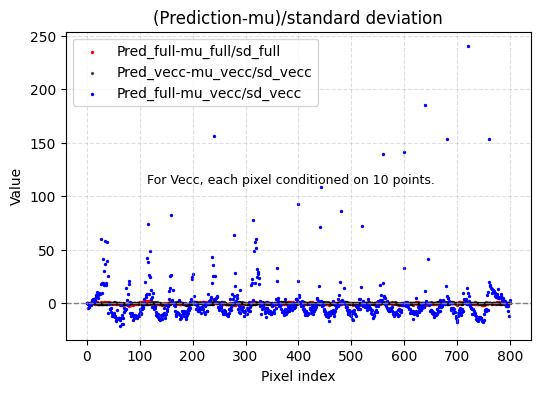

In [ ]:
n = len(cov_mat)
out_full = [0] * n
out_vecc = [0] * n
out_vecc_full = [0] * n

avg_full = [0] * n
avg_vecc = [0] * n
sd_full = [0] * n
sd_vecc = [0] * n


for j in range(2, n):
    data = data_copy.copy(deep=True)
    data = data.reset_index(drop=True)
    n = len(cov_mat)

    lin_coef = list(range(n))
    lin_coef.remove(j)

    lin_coef2 = list(range(j, 0, -1)) + list(range(1, n - j))

    sigma = cov_mat.iloc[lin_coef, lin_coef]
    gamma = cov_mat.iloc[0, lin_coef2]
    coef = np.linalg.solve(sigma, gamma)

    x_data = data['ColumnAmountO3']
    x_data.pop(j)

    avg_full[j] = np.dot(coef.T, np.ones(coef.shape) * np.mean(x_data))
    predictor_full = np.dot(coef.T, x_data)

    sd_full[j] = np.sqrt(np.dot(gamma.T, coef))

    out_full[j] = (predictor_full - avg_full[j]) / sd_full[j]

    ##################################

    d2 = data.iloc[[j] + list(nns_map[j]), :]
    cov = instance.matern_cov_yx(params, d2, d2)

    
    sigma = cov.iloc[1:, 1:]
    gamma = cov.iloc[0, 1:]
    coef_vecc = np.linalg.solve(sigma, gamma)

    x_data_vecc = d2['ColumnAmountO3']
    x_data_vecc.pop(j)

    avg_vecc[j] = np.dot(coef_vecc.T, np.ones(coef_vecc.shape) * np.mean(x_data_vecc))
    predictor_vecc = np.dot(coef_vecc.T, x_data_vecc)
    sd_vecc[j] = np.sqrt(np.dot(gamma.T, coef_vecc))

    out_vecc[j] = (predictor_vecc - avg_vecc[j] ) / (sd_vecc[j] )
    out_vecc_full[j] = (predictor_full - avg_vecc[j] ) / (sd_vecc[j] )
   
# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(range(len(out_full)), out_full, s=2, color='red', label='Pred_full-mu_full/sd_full')
plt.scatter(range(len(out_vecc)), out_vecc, s=2, color='black', label='Pred_vecc-mu_vecc/sd_vecc', alpha=0.6)

plt.scatter(range(len(out_vecc)), out_vecc_full, s=2, color='blue', label='Pred_full-mu_vecc/sd_vecc')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Pixel index')
plt.ylabel('Value')
plt.legend()
plt.title('(Prediction-mu)/standard deviation')
plt.grid(True, linestyle='--', alpha=0.4)
plt.figtext(0.5, 0.5, 'For Vecc, each pixel conditioned on 10 points.', ha='center', fontsize=9, color='black')
plt.show()

It seems they are quite different, let's see how sds and means behave.

The sd and mean plots show that the performance of kriging vary by predicting location. Generally it is good for interpolating. 

I think it makes sense that Vecchia results in smaller standard deviation because it chooses the most relevant set as conditioning set, not the entire past data. 

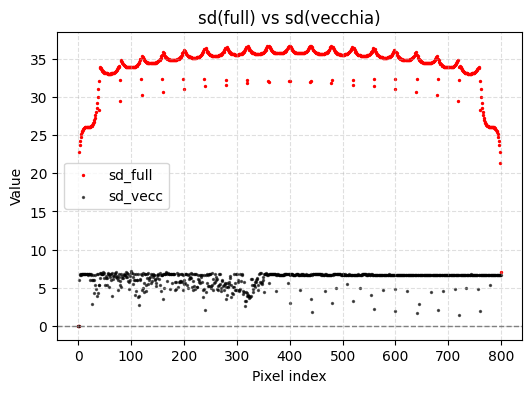

In [462]:
# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(range(len(sd_full)), sd_full, s=2, color='red', label='sd_full')
plt.scatter(range(len(sd_vecc)), sd_vecc, s=2, color='black', label='sd_vecc', alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Pixel index')
plt.ylabel('Value')
plt.legend()
plt.title('sd(full) vs sd(vecchia)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

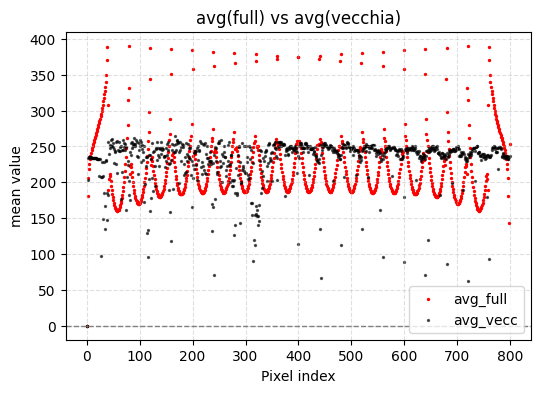

In [464]:
# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(range(len(avg_full)), avg_full, s=2, color='red', label='avg_full')
plt.scatter(range(len(avg_vecc)), avg_vecc, s=2, color='black', label='avg_vecc', alpha=0.6)

plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('Pixel index')
plt.ylabel('mean value')
plt.legend()
plt.title('avg(full) vs avg(vecchia)')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

# Reference 

# Full covariance matrix

We can see that the normalized value using the full data looks like standard normal.

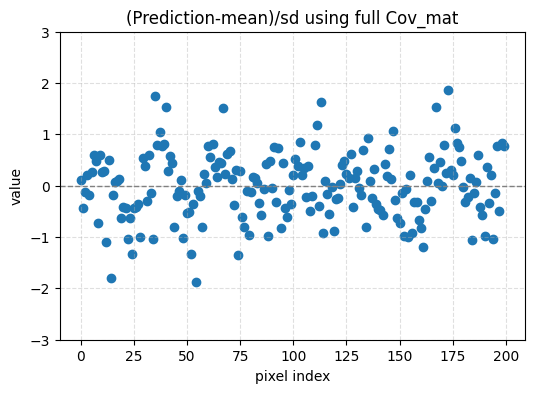

In [465]:
n = len(cov_mat)
out_full = [0]*n
for j in range(n):
    data = data_copy.copy(deep=True)
    data = data.reset_index(drop=True)
    n = len(cov_mat)

    lin_coef = list(range(n))
    lin_coef.remove(j)

    lin_coef2 = list(range(j,0,-1)) + list(range(1, (n-j)))
    lin_coef2

    # print(np.sum(cov_mat))

    sigma = cov_mat.iloc[lin_coef, lin_coef]
    gamma = cov_mat.iloc[0, lin_coef2]

    coef = np.linalg.solve(sigma, gamma )
    # print( np.mean ( data['ColumnAmountO3']))
    # x_data = data['ColumnAmountO3'] - np.mean(data['ColumnAmountO3'])
    x_data = data['ColumnAmountO3']
    x_data.pop(j)

    x_mean_full  = np.dot(coef.T, np.ones( coef.shape)* np.mean(x_data))
    predictor_full = np.dot(coef.T,x_data)

    sd_full = np.sqrt(np.dot(gamma.T,coef))

    out_full[j] = (predictor_full- x_mean_full)/sd_full


# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(list(range(len(out))),out)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('pixel index')
plt.ylabel('value')
plt.ylim(-3,3)
plt.title('(Prediction-mean)/sd using full Cov_mat')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()




# Vecchia approximation

One observation is that normalized value has smaller standard deviation compared to the normalized value above using the full data. 

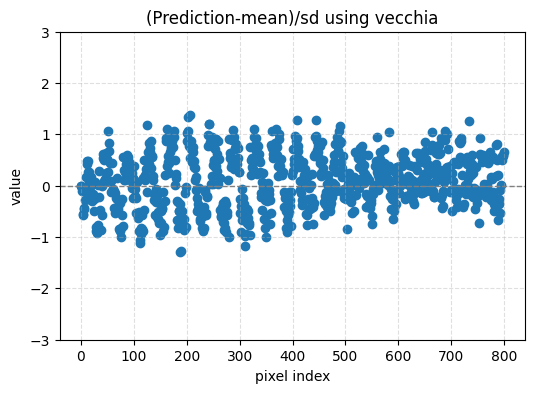

In [466]:
n = len(cov_mat)
out = [0]*n
for j in range(2,n):
    data = data_copy.copy(deep=True)
    n = len(cov_mat)

    d2 = data.iloc[(list([j])+ list(nns_map[j])),:]
    
    cov = instance.matern_cov_yx( params, d2,d2)
    # print(np.sum(cov_mat))

    sigma = cov.iloc[1:,1:]
    gamma = cov.iloc[0, 1:]
  
    coef = np.linalg.solve(sigma, gamma )

    demean_data = d2['ColumnAmountO3'] - np.mean(d2['ColumnAmountO3'])
    
    demean_data = d2['ColumnAmountO3']
    demean_data.pop(j)
    predictor = demean_data - np.mean (d2['ColumnAmountO3'])

    sd = np.sqrt(np.dot(gamma.T,coef))

    out[j] = np.dot(coef.T, predictor)/sd

# Create scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(list(range(len(out))),out)
plt.axhline(0, color='gray', linestyle='--', linewidth=1)

plt.xlabel('pixel index')
plt.ylabel('value')
plt.ylim(-3,3)
plt.title('(Prediction-mean)/sd using vecchia')
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()